In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,roc_curve,confusion_matrix,RocCurveDisplay
from sklearn.svm import LinearSVC
from sklearn.preprocessing import Normalizer,label_binarize
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans,SpectralClustering
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
import warnings
warnings.filterwarnings('ignore')


(a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set from:
https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29. Download the data in https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data, which has IDs, classes (Benign=B, Malignant=M), and 30 attributes. This data has two output classes.


In [2]:
wdbc = pd.read_csv('../Data/wdbc.data',header=None)
wdbc_label = wdbc[1]
wdbc_label = label_binarize(wdbc_label,classes=['B','M'])
wdbc = wdbc.drop([1],axis=1)


(b) Monte-Carlo Simulation: Repeat the following procedures for supervised, unsupervised, and semi-supervised learning M = 30 times, and use randomly selected train and test data (make sure you use 20% of both the positve and negative classes as the test set). Then compare the average scores (accuracy, precision, recall, F1-score, and AUC) that you obtain from each algorithm.

i. Supervised Learning: Train an L1-penalized SVM to classify the data. Use 5 fold cross validation to choose the penalty parameter. Use normalized data. Report the average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs. Plot the ROC and report the confusion matrix for training and testing in one of the runs.


In [3]:
def plot_metrics(y_train,train_pred,y_test,test_pred):
    fpr, tpr, threshold = roc_curve(y_train,train_pred)
    cm = confusion_matrix(y_train,train_pred)
    print("train set's confusion matrix:",'\n',cm)
    auc_score = roc_auc_score(y_train,train_pred)
    RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=auc_score).plot()
    plt.title('the ROC curve and AUC of training set')

    fpr, tpr, threshold = roc_curve(y_test,test_pred)
    cm = confusion_matrix(y_test,test_pred)
    print("test set's confusion matrix:",'\n',cm)
    auc_score = roc_auc_score(y_test,test_pred)
    RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=auc_score).plot()
    plt.title('the ROC curve and AUC of test set')

In [4]:
def metrics_record(model,y_train,train_pred,y_test,test_pred):
    acc_train = accuracy_score(y_train,train_pred)
    prec_train = precision_score(y_train,train_pred)
    rec_train = recall_score(y_train,train_pred)
    f1_train = f1_score(y_train,train_pred)
    auc_train = roc_auc_score(y_train,train_pred)
    model['train']['acc'] = model['train'].get('acc',[])+[acc_train]
    model['train']['prec'] = model['train'].get('prec',[])+[prec_train]
    model['train']['rec'] = model['train'].get('rec',[])+[rec_train]
    model['train']['f1'] = model['train'].get('f1',[])+[f1_train]
    model['train']['auc'] = model['train'].get('auc',[])+[auc_train]

    acc_test = accuracy_score(y_test,test_pred)
    prec_test = precision_score(y_test,test_pred)
    rec_test = recall_score(y_test,test_pred)
    f1_test = f1_score(y_test,test_pred)
    auc_test = roc_auc_score(y_test,test_pred)
    model['test']['acc'] = model['test'].get('acc',[])+[acc_test]
    model['test']['prec'] = model['test'].get('prec',[])+[prec_test]
    model['test']['rec'] = model['test'].get('rec',[])+[rec_test]
    model['test']['f1'] = model['test'].get('f1',[])+[f1_test]
    model['test']['auc'] = model['test'].get('auc',[])+[auc_test]

100%|██████████| 30/30 [00:12<00:00,  2.45it/s]


train set's confusion matrix: 
 [[283   2]
 [ 38 132]]
test set's confusion matrix: 
 [[71  1]
 [11 31]]
{'train': {'acc': 0.9142857142857144, 'prec': 0.9851777360306005, 'rec': 0.7821568627450979, 'f1': 0.871319709031997, 'auc': 0.8876281389748881}, 'test': {'acc': 0.899122807017544, 'prec': 0.949863665400753, 'rec': 0.7682539682539681, 'f1': 0.8475744430484329, 'auc': 0.8718584656084656}}


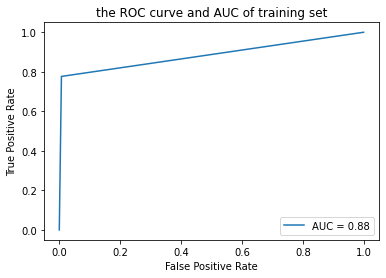

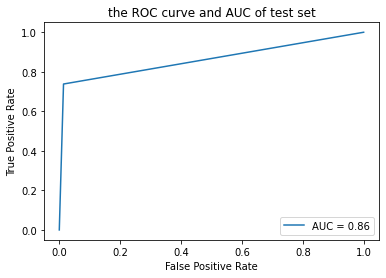

In [5]:

metrics = {}
best = []
l1svc = {'train':{},'test':{}}
for i in trange(30):
    x_train, x_test, y_train, y_test = train_test_split(wdbc,wdbc_label,test_size=0.2,stratify=wdbc_label)
    norm = Normalizer()
    svm = LinearSVC(penalty='l1',dual=False)
    pip = Pipeline([('scaler',Normalizer()),('svc',svm)])
    param = {'svc__C':[1e15,1e16,1e17,1e18]}
    cv = GridSearchCV(pip,param,cv=5)
    cv = cv.fit(x_train,y_train)
    best.append(cv.best_params_['svc__C'])
    pred_cv = cv.predict(x_test)
    pred_train = cv.predict(x_train)
    metrics_record(l1svc,y_train,pred_train,y_test,pred_cv)

plot_metrics(y_train,pred_train,y_test,pred_cv)

for i in l1svc['train']:
    l1svc['train'][i] = np.mean(l1svc['train'][i])
for i in l1svc['test']:
    l1svc['test'][i] = np.mean(l1svc['test'][i])

print(l1svc)


For L1-penalized SVM:

The ROC plots of the training set and test set are aboved.
The training set confusion matrix:

||predicted B|predicted M|
|--------|--------|--------|
|actual B|283|2|
|actual M|38|132|

The test set confusion matrix:

||predicted B|predicted M|
|--------|--------|--------|
|actual B|71|1|
|actual M|11|31|

The average metrics of both training set and tests set over 30 runs are:
||accuracy|precision|recall|F1-score|auc|
|--------|--------|--------|--------|--------|--------|
|training|0.91|0.99|0.78|0.87|0.89|
|test|0.90|0.95|0.77|0.85|0.86|

ii. Semi-Supervised Learning/ Self-training: select 50% of the positive class along with 50% of the negative class in the training set as labeled data and the rest as unlabelled data. You can select them randomly.

A. Train an L1-penalized SVM to classify the labeled data Use normalized data. Choose the penalty parameter using 5 fold cross validation.

B. Find the unlabeled data point that is the farthest to the decision boundary of the SVM. Let the SVM label it (ignore its true label), and add it to the labeled data, and retrain the SVM. Continue this process until all unlabeled data are used. Test the final SVM on the test data andthe average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs. Plot the ROC and report the confusion matrix for training and testing in one of the runs.

100%|██████████| 30/30 [24:55<00:00, 49.84s/it]


train set's confusion matrix: 
 [[274  11]
 [ 43 127]]
test set's confusion matrix: 
 [[68  4]
 [11 31]]
{'train': {'acc': 0.8728937728937729, 'prec': 0.8532107689476905, 'rec': 0.8401960784313726, 'f1': 0.8321895436300432, 'auc': 0.8662968696250429}, 'test': {'acc': 0.8482456140350877, 'prec': 0.8224792307134497, 'rec': 0.7984126984126984, 'f1': 0.7930520970316786, 'auc': 0.8378637566137566}}


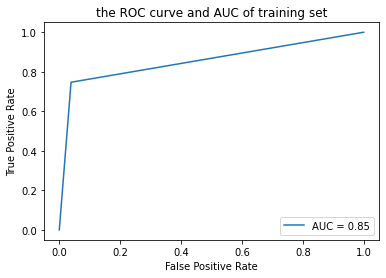

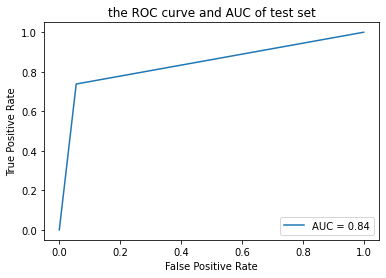

In [6]:
semisvc={'train':{},'test':{}}
for i in trange(30):
    x_train, x_test, y_train, y_test = train_test_split(wdbc,wdbc_label,test_size=0.2,stratify=wdbc_label)
    label_x, unlabel_x, label_y, unlabel_y = train_test_split(x_train,y_train,test_size=0.5,stratify=y_train)
    for j in range(len(unlabel_x)):
        norm = Normalizer()
        svm = LinearSVC(penalty='l1',dual=False)
        pip = Pipeline([('scaler',Normalizer()),('svc',svm)])
        param = {'svc__C':[1e15,1e16,1e17]}
        cv = GridSearchCV(pip,param,cv=5)
        cv = cv.fit(label_x,label_y)
        dis = cv.decision_function(unlabel_x)
        unlabel_x.index = range(len(unlabel_x))
        new_label = unlabel_x.loc[np.argmax(dis),:]
        unlabel_x = unlabel_x.drop(np.argmax(dis),axis=0)
        label_x = label_x.append(new_label)
        label_y = np.append(label_y,cv.predict(np.array(new_label).reshape(1,-1)))
    norm = Normalizer()
    svm = LinearSVC(penalty='l1',dual=False)
    pip = Pipeline([('scaler',Normalizer()),('svc',svm)])
    param = {'svc__C':[1e15,1e16,1e17]}
    cv = GridSearchCV(pip,param,cv=5)
    cv = cv.fit(label_x,label_y)
    pred_test = cv.predict(x_test)
    pred_train = cv.predict(x_train)
    metrics_record(semisvc,y_train,pred_train,y_test,pred_test)

plot_metrics(y_train,pred_train,y_test,pred_test)
for i in semisvc['train']:
    semisvc['train'][i] = np.mean(semisvc['train'][i])
for i in semisvc['test']:
    semisvc['test'][i] = np.mean(semisvc['test'][i])
print(semisvc)



For semi-supervised L1-penalized SVM:

The ROC plots of the training set and test set are aboved.
The training set confusion matrix:

||predicted B|predicted M|
|--------|--------|--------|
|actual B|274|11|
|actual M|43|127|

The test set confusion matrix:

||predicted B|predicted M|
|--------|--------|--------|
|actual B|68|4|
|actual M|11|13|

The average metrics of both training set and tests set over 30 runs are:
||accuracy|precision|recall|F1-score|auc|
|--------|--------|--------|--------|--------|--------|
|training|0.87|0.85|0.85|0.84|0.83|
|test|0.85|0.82|0.80|0.79|0.84|

iii. Unsupervised Learning: Run k-means algorithm on the whole training set. Ignore the labels of the data, and assume k = 2.

A. Run the k-means algorithm multiple times. Make sure that you initialize the algoritm randomly. How do you make sure that the algorithm was not trapped in a local minimum?

B. Compute the centers of the two clusters and find the closest 30 data points to each center. Read the true labels of those 30 data points and take a majority poll within them. The majority poll becomes the label predicted by k-means for the members of each cluster. Then compare the labels provided by k-means with the true labels of the training data and report the average accuracy, precision, recall, F1-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs.

C. Classify test data based on their proximity to the centers of the clusters. Report the average accuracy, precision, recall, F1-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs for the test data.

A. Kmeans cluster algorithm always take the risk trapped in a local minimum, we can increase the parameter 'n_init' to reduce that kind of risk, which is a parameter that control how many times the algorithm run with different centroid seeds and return the best result.
Also repeat the algorithm multiple times and choose the result of less sum of distances is also a good way to reduce the risk of trapped in local minimum.

100%|██████████| 30/30 [00:06<00:00,  4.60it/s]

train set's confusion matrix: 
 [[285   0]
 [170   0]]
test set's confusion matrix: 
 [[72  0]
 [42  0]]


{'train': {'acc': 0.6263736263736265,
  'prec': 0.0,
  'rec': 0.0,
  'f1': 0.0,
  'auc': 0.5},
 'test': {'acc': 0.631578947368421,
  'prec': 0.0,
  'rec': 0.0,
  'f1': 0.0,
  'auc': 0.5}}

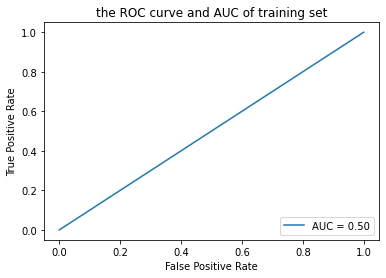

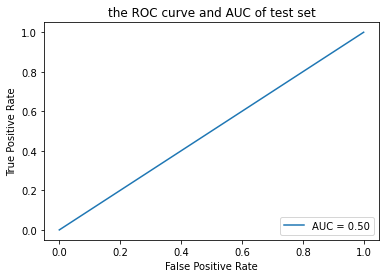

In [7]:
kmcluster = {'train':{},'test':{}}
for i in trange(30):
    x_train, x_test, y_train, y_test = train_test_split(wdbc,wdbc_label,test_size=0.2,stratify=wdbc_label)
    x_train = Normalizer().fit_transform(x_train)
    cluster = KMeans(n_clusters=2,n_init=100)
    cluster_dis = cluster.fit_transform(x_train)
    cluster_0_list = pd.DataFrame(cluster_dis).sort_values(by=0,ascending=False)[:30].index
    cluster_1_list = pd.DataFrame(cluster_dis).sort_values(by=1,ascending=False)[:30].index
 #   print(set(cluster_0_list).intersection(set(cluster_1_list)))
    cluster_0_pred = pd.DataFrame(y_train).loc[cluster_0_list,:].mode()[0][0]
    cluster_1_pred = pd.DataFrame(y_train).loc[cluster_1_list,:].mode()[0][0]
    cluster_pred = cluster.predict(x_train)
    cluster_pred = np.where(cluster_pred==0,cluster_0_pred,cluster_1_pred)
    test_pred = cluster.predict(x_test)
    test_pred = np.where(test_pred==0,cluster_0_pred,cluster_1_pred)
    metrics_record(kmcluster,y_train,cluster_pred,y_test,test_pred)
    
plot_metrics(y_train,cluster_pred,y_test,test_pred)
for i in kmcluster['train']:
    kmcluster['train'][i] = np.mean(kmcluster['train'][i])
for i in kmcluster['test']:
    kmcluster['test'][i] = np.mean(kmcluster['test'][i])
kmcluster

For kmeans cluster:

The ROC plots of the training set and test set are aboved.
The training set confusion matrix:

||predicted B|predicted M|
|--------|--------|--------|
|actual B|285|0|
|actual M|170|0|

The test set confusion matrix:

||predicted B|predicted M|
|--------|--------|--------|
|actual B|72|0|
|actual M|42|0|

The average metrics of both training set and tests set over 30 runs are:
||accuracy|precision|recall|F1-score|auc|
|--------|--------|--------|--------|--------|--------|
|training|0.63|0.00|0.00|0.00|0.50|
|test|0.63|0.00|0.00|0.00|0.50|

iv. Spectral Clustering: Repeat 1(b)iii using spectral clustering, which is clustering based on kernels. Research what spectral clustering is. Use RBF kernel with gamma=1 or find a gamma for which the two clutsres have the same balance as the one in original data set (if the positive class has p and the negative class has n samples, the two clusters must have p and n members). Do not label data based on their proximity to cluster center, because spectral clustering may give you non-convex clusters. Instead, use fit−predict method.


Ans: Spectral clustering is a clustering algorithm based on graph theory, which cluster data based on the edges connecting them. The edges between data define the similarity of the two related data. Spectral clustering is calculated from eigenvalues and eigenvectors and the clustering of the vector may not necessarily have convex boundaries.

100%|██████████| 30/30 [00:02<00:00, 11.07it/s]

train set's confusion matrix: 
 [[286   0]
 [170   0]]
test set's confusion matrix: 
 [[71  0]
 [42  0]]


{'train': {'acc': 0.6105994152046782,
  'prec': 0.0531782635201767,
  'rec': 0.08549019607843136,
  'f1': 0.06495145286235568,
  'auc': 0.5041087344028521},
 'test': {'acc': 0.6103244837758113,
  'prec': 0.050503224545632205,
  'rec': 0.08174603174603175,
  'f1': 0.06194118776542876,
  'auc': 0.5023753632908563}}

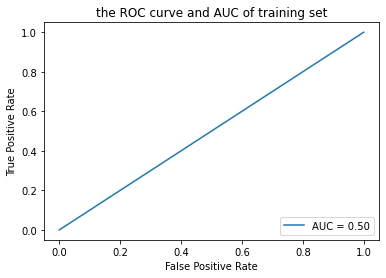

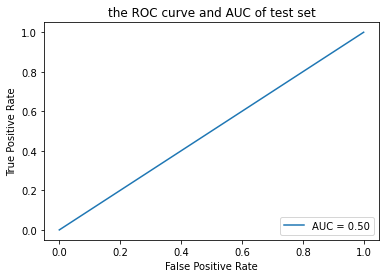

In [8]:
scluster={'train':{},'test':{}}
for i in trange(30):
    kfold = StratifiedKFold(n_splits=5,shuffle=True)
    for train_index,test_index in kfold.split(wdbc,wdbc_label):
        trainset,testset = train_index,test_index
        x_train,x_test = wdbc.loc[trainset,:],wdbc.loc[testset,:]
        y_train,y_test = wdbc_label[trainset],wdbc_label[testset]
        scaler = Normalizer().fit(x_train)
        wdbc_scaled = scaler.transform(wdbc)
    cluster = SpectralClustering(n_clusters=2,gamma=2)
    cluster_pred = cluster.fit_predict(wdbc)
    train_pred = cluster_pred[trainset]
    cluster_0_pred = pd.DataFrame(y_train[train_pred==0]).sample(30).mode().loc[0,0]
    cluster_1_pred = pd.DataFrame(y_train[train_pred==1]).sample(30).mode().loc[0,0]
    cluster_pred = np.where(cluster_pred==0,cluster_0_pred,cluster_1_pred)
    test_pred = cluster_pred[testset]
    train_pred = cluster_pred[trainset]
    metrics_record(scluster,y_train,train_pred,y_test,test_pred)

plot_metrics(y_train,train_pred,y_test,test_pred)
for i in scluster['train']:
    scluster['train'][i] = np.mean(scluster['train'][i])
for i in scluster['test']:
    scluster['test'][i] = np.mean(scluster['test'][i])
scluster


For Spectral Clustering:

The ROC plots of the training set and test set are aboved.
The training set confusion matrix:

||predicted B|predicted M|
|--------|--------|--------|
|actual B|286|0|
|actual M|170|0|

The test set confusion matrix:

||predicted B|predicted M|
|--------|--------|--------|
|actual B|71|0|
|actual M|42|0|

The average metrics of both training set and tests set over 30 runs are:
||accuracy|precision|recall|F1-score|auc|
|--------|--------|--------|--------|--------|--------|
|training|0.62|0.05|0.09|0.06|0.50|
|test|0.62|0.05|0.08|0.06|0.50|

v. One can expect that supervised learning on the full data set works better than semi-supervised learning with half of the data set labeled.One can expect that unsupervised learning underperforms in such situations. Compare the results you obtained by those methods.

In [9]:
metrics = {'l1svc':l1svc['test'],'semi-svc':semisvc['test'],'kmeans':kmcluster['test'],'spectural':scluster['test']}
metric = pd.DataFrame.from_dict(metrics,orient='index')
metric

,acc,prec,rec,f1,auc
l1svc,0.899123,0.949864,0.768254,0.847574,0.871858
semi-svc,0.848246,0.822479,0.798413,0.793052,0.837864
kmeans,0.631579,0.000000,0.000000,0.000000,0.500000
spectural,0.610324,0.050503,0.081746,0.061941,0.502375


Campare the test set metrics:

|model|accuracy|precision|recall|F1-score|auc|
|--------|--------|--------|--------|--------|--------|
|l1svc|0.90|0.95|0.77|0.85|0.87|
|semi-l1svc|0.85|0.82|0.80|0.79|0.84|
|kmean cluster|0.63|0.00|0.00|0.00|0.50|
|spectural cluster|0.61|0.05|0.08|0.06|0.50|

The supervised learning model(l1svc) has the best performance, and the semi-supervised model(semi-l1svc) performs better than unsupervised learning(kmeans and sepctural cluster).

For classification, spectural cluster model has a little higher discrimination than kmeans cluster but less in accuracy. But This two unsupervised models have no discrimination since their average auc are both 0.5 and they almost classifify every sample into class 'B'.

2. Active Learning Using Support Vector Machines

(a) Download the banknote authentication Data Set from: https://archive.ics.uci.edu/ml/datasets/banknote+authentication. Choose 472 data points ran- domly as the test set, and the remaining 900 points as the training set. This is a binary classification problem.


In [10]:
ba = pd.read_csv('../Data/data_banknote_authentication.txt',header=None,names=['variance','skewness','curtosis','entropy','class'])
y = ba.pop('class')

i. Train a SVM with a pool of 10 randomly selected data points from the training set using linear kernel and L1 penalty. Select the penalty parameter using 5-fold cross validation. Repeat this process by adding 10 other randomly selected data points to the pool, until you use all the 900 points. Do NOT replace the samples back into the training set at each step. Calculate the test error for each SVM. You will have 90 SVMs that were trained using 10, 20, 30, ... , 900 data points and their 90 test errors. You have implemented passive learning.


In [11]:
passive = {}
for j in trange(50):
    x_train,x_test,y_train,y_test = train_test_split(ba,y,train_size=900)
    trainset = pd.DataFrame([])
    trainclass = pd.Series([])
    for i in range(90):
        tmp = x_train.sample(10)
        tmp_index = tmp.index
        tmp_class = y_train[tmp_index]
        trainset = trainset.append(tmp)
        trainclass = trainclass.append(tmp_class)
        x_train = x_train.drop(tmp_index,axis=0)
        norm = Normalizer()
        svm = LinearSVC(penalty='l1',dual=False)
        pip = Pipeline([('scaler',Normalizer()),('svc',svm)])
        param = {'svc__C':[1e-3,1e-2,1e-1,1,10,100,1e3,1e4,1e5]}
        cv = GridSearchCV(pip,param,cv=5)
        cv = cv.fit(trainset,trainclass)
        pred_cv = cv.predict(x_test)
        passive[(i+1)*10] = passive.get((i+1)*10,[])+[1-accuracy_score(y_test,pred_cv)]


100%|██████████| 50/50 [10:07<00:00, 12.15s/it]


ii. Train a SVM with a pool of 10 randomly selected data points from the training set using linear kernel and L1 penalty. Select the parameters of the SVM with 5-fold cross validation. Choose the 10 closest data points in the training set to the hyperplane of the SVM6 and add them to the pool. Do not replace the samples back into the training set. Train a new SVM using the pool. Repeat this process until all training data is used. You will have 90 SVMs that were trained using 10, 20, 30,..., 900 data points and their 90 test errors. You have implemented active learning.

In [12]:
active = {}
for j in trange(50):
    x_train,x_test,y_train,y_test = train_test_split(ba,y,train_size=900)
    trainset = pd.DataFrame([])
    trainclass = pd.Series([])
    tmp = x_train.sample(10)
    tmp_index = tmp.index
    tmp_class = y_train[tmp_index]
    trainset = trainset.append(tmp)
    trainclass = trainclass.append(tmp_class)
    x_train = x_train.drop(tmp_index,axis=0)
    x_train.index = range(len(x_train))
    y_train = y_train.drop(tmp_index)
    y_train.index = range(len(y_train))
    norm = Normalizer()
    svm = LinearSVC(penalty='l1',dual=False)
    pip = Pipeline([('scaler',Normalizer()),('svc',svm)])
    param = {'svc__C':[1e-3,1e-2,1e-1,1,10,100,1e3,1e4,1e5]}
    cv = GridSearchCV(pip,param,cv=5)
    cv = cv.fit(trainset,trainclass)
    best.append(cv.best_params_['svc__C'])
    pred_cv = cv.predict(x_test)
    active[10] = active.get(10,[])+[accuracy_score(y_test,pred_cv)]
    dis_cv = cv.decision_function(x_train)
    for i in range(89):
        tmp_index = np.argsort(dis_cv)[:10]
        trainset = trainset.append(x_train.loc[tmp_index,:])
        trainclass = trainclass.append(y_train[tmp_index])
        x_train = x_train.drop(tmp_index,axis=0)
        y_train = y_train.drop(tmp_index)
        x_train.index = range(len(x_train))
        y_train.index = range(len(y_train))
        norm = Normalizer()
        svm = LinearSVC(penalty='l1',dual=False)
        pip = Pipeline([('scaler',Normalizer()),('svc',svm)])
        param = {'svc__C':[1e-3,1e-2,1e-1,1,10,100,1e3,1e4,1e5]}
        cv = GridSearchCV(pip,param,cv=5)
        cv = cv.fit(trainset,trainclass)
        pred_cv = cv.predict(x_test)
        active[(i+2)*10] = active.get((i+2)*10,[])+[1-accuracy_score(y_test,pred_cv)]
        if i < 88:
            dis_cv = cv.decision_function(x_train)


100%|██████████| 50/50 [09:17<00:00, 11.15s/it]


(c) Average the 50 test errors for each of the incrementally trained 90 SVMs in 2(b)i and 2(b)ii. By doing so, you are performing a Monte Carlo simulation. Plot average test error versus number of training instances for both active and passive learners on the same figure and report your conclusions. Here, you are actually obtaining a learning curve by Monte-Carlo simulation.

In [13]:
for i in passive:
    passive[i] = np.mean(passive[i])

for i in active:
    active[i] = np.mean(active[i])

MC_res = {'passive':passive,'active':active}
MC_res = pd.DataFrame.from_dict(MC_res)
MC_res['size'] = MC_res.index

In [14]:
MC_res

,passive,active,size
10,0.165763,0.834831,10
20,0.069703,0.138136,20
30,0.042034,0.130000,30
40,0.023898,0.126568,40
50,0.023347,0.116568,50
...,...,...,...
860,0.007797,0.009025,860
870,0.007669,0.008983,870
880,0.007542,0.008898,880
890,0.007754,0.009110,890


In [15]:
MC_res_plot = MC_res.melt(id_vars='size',var_name = 'model',value_name='accuracy')
MC_res_plot

,size,model,accuracy
0,10,passive,0.165763
1,20,passive,0.069703
2,30,passive,0.042034
3,40,passive,0.023898
4,50,passive,0.023347
...,...,...,...
175,860,active,0.009025
176,870,active,0.008983
177,880,active,0.008898
178,890,active,0.009110


Text(0.5, 1.0, 'Learning curve of Monte-Carlo simulation')

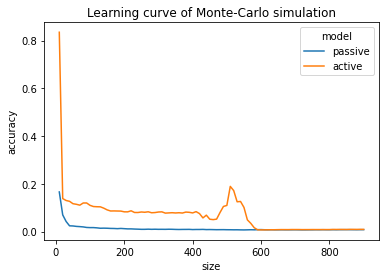

In [16]:
sns.lineplot(data=MC_res_plot,x='size',y='accuracy',hue='model')
plt.title('Learning curve of Monte-Carlo simulation')

According to the accuracy and the learning curve plot, we can tell that passive learning performance better and converge faster.

【reference】
1. Sklearn api reference: https://scikit-learn.org/stable/modules/classes.html
2. Pandas api reference: https://pandas.pydata.org/pandas-docs/stable/reference/index.html
3. Kmeans cluster wikipedia: https://en.wikipedia.org/wiki/K-means_clustering
4. Spectral clustering wikipedia: https://en.wikipedia.org/wiki/Spectral_clustering
5. Spectral clustering from towardsdatascience: https://towardsdatascience.com/spectral-clustering-aba2640c0d5b
6. What, why and how of spectral clustering: https://www.analyticsvidhya.com/blog/2021/05/what-why-and-how-of-spectral-clustering/
7. Avoiding local minimum when using kmeans - stackoverflow: https://stackoverflow.com/questions/43789602/avoiding-local-minima-when-using-kmeans
